In [50]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
scores = pd.read_csv('data/historical_round_scores.csv')
pre_tourney = pd.read_csv('pre_tourney_snapshot_2021_08_24.csv')

In [54]:
scores['fin_num'] = (np.where(scores.fin_text.isin(early_outs),
                             early_out_num,
                             scores.fin_text.str.replace('T',''))
                    ).astype(int)

In [73]:
scores['year_event_id'] = scores['year'].astype(str) + '_' + scores['event_id'].astype(str)
max_fin_dict = scores.groupby('year_event_id')['fin_num'].max().to_dict()

In [81]:
scores['year_event_golfer'] = (scores['year'].astype(str) +
                                      '_' + scores['event_id'].astype(str) +
                                      '_' + scores['dg_id'].astype(str)
                              )

early_outs = ['CUT','DQ','WD', 'W/D', 'MDF',]
early_out_num = 75

scores['early_out'] = np.where(scores.fin_text.isin(early_outs), scores.year_event_id.map(max_fin_dict),0)

# Aggregating round data to an event level
event_df = (scores.groupby(['dg_id','player_name','event_name',
                            'event_id','fin_text','fin_num','early_out',
                            'year','year_event_golfer','event_completed',]).
            agg(rounds=('round','count'),
                mean_score = ('score', 'mean'),
                mean_sg = ('sg_total', 'mean')
               ).reset_index().sort_values('event_completed')
           )

majors = ['Masters Tournament','The Masters','The Masters #2','The Open Championship',
          'U.S. Open','U.S. Open #2','PGA Championship',
         ]

event_df['major'] = np.where(event_df['event_name'].isin(majors), 1, 0)

event_df['won_major'] = np.where((event_df['major'] == 1) & (event_df.fin_num == 1), 1, 0)

event_df['top_10'] = np.where(event_df['fin_num'] <= 10, 1, 0)

In [82]:
def create_rolling_agg_features_by_golfer(df, field, n_shift, n_rolling, agg_func):
    """
    """
    df = df.copy()
    
    df['shifted_field'] = (df.groupby('dg_id')[field]
                           .shift(n_shift)
                           .fillna(0)
                          )
    
    return (df.groupby('dg_id')['shifted_field']
            .transform(lambda x: x.rolling(n_rolling, min_periods=1)
                       .agg(agg_func))
           )

In [83]:
metric_lst = [
    {'field': 'early_out','periods': [1, 2, 5], 'agg': 'sum'},
    {'field': 'fin_num', 'periods': [1, 2, 5], 'agg': 'mean'},
    {'field': 'mean_sg', 'periods': [1, 2, 5], 'agg':'mean'},
    {'field': 'won_major', 'periods': [50], 'agg':'sum'},
    {'field': 'top_10', 'periods': [5, 10], 'agg': 'sum'},
    ]


In [84]:
for metric in metric_lst:
    field = metric.get('field')
    agg = metric.get('agg')
    for period in metric.get('periods'):
        col = f"{field}_in_prev_{period}_events"
        event_df[col] = create_rolling_agg_features_by_golfer(event_df, field, 1, period, agg)

In [85]:
# fin_by_course = (scores[['course_num', 'course_name', 'dg_id', 'player_name','event_completed','fin_num']]
#                  .drop_duplicates()
#                  .sort_values('event_completed')
#                 )

# fin_by_course['prev_fin_on_course'] = fin_by_course.groupby(['dg_id','course_num'])['fin_num'].shift(1).fillna(40)

## Analysis

In [86]:
feat_cols = ['early_out_in_prev_1_events','early_out_in_prev_2_events',
             'early_out_in_prev_5_events','fin_num_in_prev_1_events', 
             'fin_num_in_prev_2_events','fin_num_in_prev_5_events',
             'mean_sg_in_prev_1_events','mean_sg_in_prev_2_events', 
             'mean_sg_in_prev_5_events','won_major_in_prev_50_events',
             'top_10_in_prev_5_events', 'top_10_in_prev_10_events',
            ]

target_col = 'fin_num'

In [87]:
event_df[feat_cols + [target_col]].corr().loc['fin_num']

early_out_in_prev_1_events     0.145564
early_out_in_prev_2_events     0.139686
early_out_in_prev_5_events     0.152184
fin_num_in_prev_1_events       0.139591
fin_num_in_prev_2_events       0.124826
fin_num_in_prev_5_events       0.129045
mean_sg_in_prev_1_events      -0.176191
mean_sg_in_prev_2_events      -0.200554
mean_sg_in_prev_5_events      -0.254089
won_major_in_prev_50_events         NaN
top_10_in_prev_5_events       -0.226405
top_10_in_prev_10_events      -0.264658
fin_num                        1.000000
Name: fin_num, dtype: float64

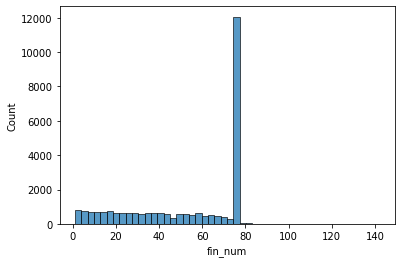

In [88]:
sns.histplot(data=event_df, x="fin_num")

### Training

In [28]:
X = event_df[feat_cols]

y = event_df['fin_num']

In [29]:
event_df.query("(dg_id == 16243) & (major == 1)")

,dg_id,player_name,event_name,event_id,fin_text,fin_num,early_out,year,year_event_golfer,event_completed,rounds,mean_score,mean_sg,major,won_major,top_10,early_out_in_prev_1_events,early_out_in_prev_2_events,early_out_in_prev_5_events,fin_num_in_prev_1_events,fin_num_in_prev_2_events,fin_num_in_prev_5_events,mean_sg_in_prev_1_events,mean_sg_in_prev_2_events,mean_sg_in_prev_5_events,won_major_in_prev_50_events,top_10_in_prev_5_events,top_10_in_prev_10_events
20488,16243,"Koepka, Brooks",Masters Tournament,14,T11,11,0,2017,2017_14_16243,2017-04-09,4,71.75,1.76975,1,0,0,1.0,1.0,3.0,75.0,61.5,63.0,-0.86200,-0.656250,-1.39395,0.0,0.0,0.0
20532,16243,"Koepka, Brooks",U.S. Open,26,1,1,0,2017,2017_26_16243,2017-06-18,4,68.00,5.13800,1,1,1,0.0,0.0,0.0,37.0,34.0,27.2,0.89000,0.965625,1.60840,0.0,1.0,1.0
20527,16243,"Koepka, Brooks",The Open Championship,100,T6,6,0,2017,2017_100_16243,2017-07-23,4,69.00,2.27625,1,0,1,0.0,0.0,0.0,1.0,19.0,27.0,5.13800,3.014000,1.86970,1.0,1.0,2.0
20492,16243,"Koepka, Brooks",PGA Championship,33,T13,13,0,2017,2017_33_16243,2017-08-13,4,71.00,2.09125,1,0,0,0.0,0.0,0.0,17.0,11.5,18.4,1.24675,1.761500,2.11845,1.0,2.0,3.0
20533,16243,"Koepka, Brooks",U.S. Open,26,1,1,0,2018,2018_26_16243,2018-06-17,4,70.25,4.14425,1,1,1,0.0,0.0,0.0,30.0,16.0,23.8,1.19525,2.537375,0.54785,1.0,1.0,3.0
20525,16243,"Koepka, Brooks",The Open Championship,100,T39,39,0,2018,2018_100_16243,2018-07-22,4,71.50,0.85225,1,0,0,0.0,0.0,0.0,19.0,10.0,12.6,1.68575,2.915000,2.58600,2.0,2.0,4.0
20490,16243,"Koepka, Brooks",PGA Championship,33,1,1,0,2018,2018_33_16243,2018-08-12,4,66.00,3.95250,1,1,1,0.0,1.0,1.0,5.0,40.0,27.8,2.15475,-0.370875,1.18810,2.0,2.0,3.0
20522,16243,"Koepka, Brooks",The Masters,14,T2,2,0,2019,2019_14_16243,2019-04-14,4,69.00,2.77050,1,0,1,0.0,1.0,1.0,56.0,65.5,36.8,-0.01875,-0.497125,0.29730,3.0,1.0,2.0
20491,16243,"Koepka, Brooks",PGA Championship,33,1,1,0,2019,2019_33_16243,2019-05-19,4,68.00,4.62550,1,1,1,0.0,0.0,1.0,4.0,3.0,27.8,3.31200,3.041250,1.60740,3.0,3.0,4.0
20534,16243,"Koepka, Brooks",U.S. Open,26,2,2,0,2019,2019_26_16243,2019-06-16,4,68.50,3.71925,1,0,1,0.0,0.0,0.0,50.0,25.5,22.6,0.27200,2.448750,2.19225,4.0,3.0,4.0


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [31]:
rf = RandomForestRegressor( n_estimators=100)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [33]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:
preds = rf.predict(X_test)

In [35]:
mean_absolute_error(y_test, preds)

21.09925511565247

## Make predictions

In [18]:
player_field = pre_tourney['dg_id'].unique()

In [20]:
new_event_df = event_df.append(pre_tourney[['dg_id', 'player_name','event_name',]], sort=False)
new_event_df['major'] = np.where(new_event_df.event_name.isin(majors), 1, 0)

In [21]:
for metric in metric_lst:
    field = metric.get('field')
    agg = metric.get('agg')
    for period in metric.get('periods'):
        col = f"{field}_in_prev_{period}_events"
        new_event_df[col] = create_rolling_agg_features_by_golfer(new_event_df, field, 1, period, agg)

In [22]:
new_event_df = new_event_df.loc[pd.isnull(new_event_df.fin_num)]
X_te = new_event_df[feat_cols]

In [23]:
X_te.shape

(69, 13)

In [24]:
rf.predict(X_te)

array([31.9  , 39.26 , 47.18 , 39.86 , 41.77 , 42.96 , 43.91 , 34.92 ,
       34.05 , 44.66 , 30.19 , 24.05 , 43.72 , 53.91 , 66.35 , 46.57 ,
       58.63 , 46.33 , 45.34 , 42.01 , 40.63 , 39.71 , 42.36 , 35.31 ,
       53.81 , 39.79 , 40.83 , 50.84 , 50.23 , 55.57 , 48.76 , 34.96 ,
       48.34 , 43.9  , 38.62 , 55.53 , 47.71 , 47.28 , 33.52 , 45.46 ,
       21.04 , 36.52 , 53.4  , 40.54 , 35.17 , 28.9  , 33.99 , 36.14 ,
       49.22 , 26.64 , 55.69 , 49.58 , 12.99 , 29.7  , 15.81 , 44.48 ,
       36.42 , 17.44 , 29.36 , 55.85 , 61.94 , 53.69 , 38.715, 42.6  ,
       41.14 , 45.7  , 32.57 , 50.73 , 40.94 ])

In [25]:
new_event_df['preds'] = rf.predict(X_te)

In [26]:
new_event_df['rank'] = new_event_df['preds'].rank()

In [27]:
new_event_df.sort_values('rank').head(10)

,dg_id,player_name,event_name,event_id,fin_text,fin_num,early_out,year,year_event_golfer,event_completed,rounds,mean_score,mean_sg,major,won_major,top_10,early_out_in_prev_1_events,early_out_in_prev_2_events,early_out_in_prev_5_events,fin_num_in_prev_1_events,fin_num_in_prev_2_events,fin_num_in_prev_5_events,mean_sg_in_prev_1_events,mean_sg_in_prev_2_events,mean_sg_in_prev_5_events,won_major_in_prev_50_events,top_10_in_prev_5_events,top_10_in_prev_10_events,preds,rank
52,19195,"Rahm, Jon",BMW Championship,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,1.0,3.0,3.0,18.0,3.19850,3.200375,3.887967,1.0,4.0,6.0,12.99,1.0
54,18417,"Scheffler, Scottie",BMW Championship,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,43.0,28.5,23.8,0.44850,0.875625,1.394200,0.0,2.0,4.0,15.81,2.0
57,15856,"Smith, Cameron",BMW Championship,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,2.0,3.5,16.0,3.69850,3.125625,1.953450,0.0,3.0,5.0,17.44,3.0
40,10091,"McIlroy, Rory",BMW Championship,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,43.0,27.5,22.4,0.44850,1.000625,1.358150,0.0,2.0,3.0,21.04,4.0
11,14577,"English, Harris",BMW Championship,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,31.0,17.5,17.0,0.69850,1.750625,1.994200,0.0,3.0,3.0,24.05,5.0
49,7672,"Oosthuizen, Louis",BMW Championship,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,17.0,9.5,8.4,0.80275,1.728875,2.292050,0.0,3.0,6.0,26.64,6.0
45,20770,"Munoz, Sebastian",BMW Championship,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,1.0,21.0,25.0,26.6,1.19850,1.255625,1.310350,0.0,2.0,3.0,28.90,7.0
58,14636,"Spieth, Jordan",BMW Championship,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,73.0,42.5,24.8,-1.55150,0.000625,1.350750,0.0,1.0,5.0,29.36,8.0
53,19895,"Schauffele, Xander",BMW Championship,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,16.0,31.0,19.2,1.44850,0.250625,1.358150,0.0,2.0,3.0,29.70,9.0
10,19841,"DeChambeau, Bryson",BMW Championship,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,1.0,31.0,19.5,33.2,0.69850,1.375625,0.915400,1.0,1.0,2.0,30.19,10.0
